# Question 04 
# a)

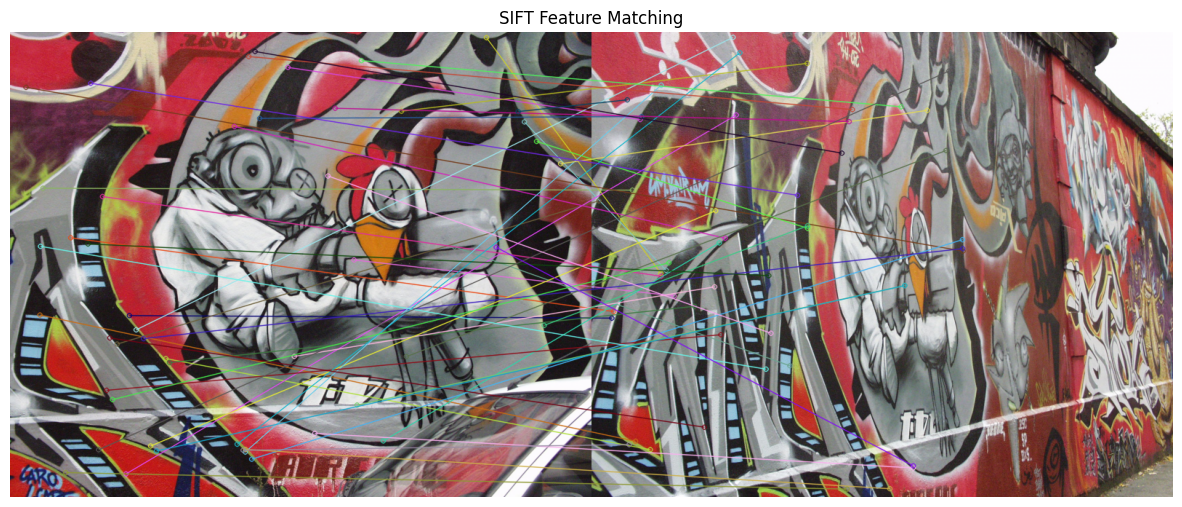

In [14]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

# Load the two images
image1 = cv2.imread('img1.ppm')
image2 = cv2.imread('img5.ppm')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Use the Brute-Force Matcher to match descriptors between the two images
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Find the best matches
matches = bf.match(descriptors1, descriptors2)

# Sort the matches based on the distance (lower distance is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the matches between the two images (you can adjust the number of matches displayed)
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert BGR to RGB for displaying in Jupyter
matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

# Display the matched image
plt.figure(figsize=(15, 10))
plt.imshow(matched_image_rgb)
plt.title('SIFT Feature Matching')
plt.axis('off') 
plt.show()


## Q04 b)


In [19]:
# Import necessary libraries
from scipy import linalg
import numpy as np
import cv2

# Initialize lists to hold original and grayscale images
images = []
gray_images = []

# List of file names to load images
file_names = ['img1.ppm', 'img2.ppm', 'img3.ppm', 'img4.ppm', 'img5.ppm']

# Load images and convert them to grayscale
for file_name in file_names:
    img = cv2.imread(file_name)  # Read the image
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    images.append(img)  # Store the original image
    gray_images.append(gray_img)  # Store the grayscale image

# Function to generate unique random indices
def random_number(n, t):
    l = np.random.randint(n, size=t)  # Generate random indices
    m = np.zeros((np.shape(l)))

    # Count occurrences of each index to ensure uniqueness
    for i in range(len(l)):
        m[i] = np.sum(l == l[i])
    if np.sum(m) == len(m):  # Check if all indices are unique
        return l
    else:
        return random_number(n, t)  # Retry if there are duplicates

# Function to calculate homography matrix from point correspondences
def calculateHomography(p1, p2):
    # Unpack point correspondences
    x1, y1, x2, y2, x3, y3, x4, y4 = p2[0], p2[1], p2[2], p2[3], p2[4], p2[5], p2[6], p2[7]
    x1T, x2T, x3T, x4T = p1[0], p1[1], p1[2], p1[3]
    zero_matrix = np.array([[0], [0], [0]])  # Create a zero matrix for calculations

    # Construct the matrix A for the homography calculation
    matrix_A = np.concatenate((
        np.concatenate((zero_matrix.T, x1T, -y1 * x1T), axis=1),
        np.concatenate((x1T, zero_matrix.T, -x1 * x1T), axis=1),
        np.concatenate((zero_matrix.T, x2T, -y2 * x2T), axis=1),
        np.concatenate((x2T, zero_matrix.T, -x2 * x2T), axis=1),
        np.concatenate((zero_matrix.T, x3T, -y3 * x3T), axis=1),
        np.concatenate((x3T, zero_matrix.T, -x3 * x3T), axis=1),
        np.concatenate((zero_matrix.T, x4T, -y4 * x4T), axis=1),
        np.concatenate((x4T, zero_matrix.T, -x4 * x4T), axis=1)
    ), axis=0)

    # Calculate eigenvalues and eigenvectors for the homography
    W, v = np.linalg.eig(((matrix_A.T) @ matrix_A))
    temph = v[:, np.argmin(W)]  # Get the eigenvector corresponding to the smallest eigenvalue
    H = temph.reshape((3, 3))  # Reshape to get the homography matrix
    return H

# Set parameters for RANSAC
p, sampleSize, outlierRatio = 0.99, 4, 0.5
N = int(np.ceil(np.log(1 - p) / np.log(1 - (1 - outlierRatio) ** sampleSize)))  # Number of iterations needed for RANSAC
Hs = []  # List to store homographies

# Loop through pairs of images
for i in range(4):
    sift = cv2.SIFT_create()  # Initialize SIFT detector
    key_points_1, descriptors_1 = sift.detectAndCompute(gray_images[i], None)  # Detect keypoints and compute descriptors for image i
    key_points_5, descriptors_5 = sift.detectAndCompute(gray_images[i + 1], None)  # Do the same for image i+1
    bf_match = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)  # Initialize the brute-force matcher
    matches = sorted(bf_match.match(descriptors_1, descriptors_5), key=lambda x: x.distance)  # Match descriptors

    # Extract source and destination points from matches
    Source_points = [key_points_1[k.queryIdx].pt for k in matches]
    Destination_points = [key_points_5[k.trainIdx].pt for k in matches]

    threshold, best_inliers, best_H = 2, 0, 0  # Initialize threshold and best parameters

    # RANSAC loop for homography estimation
    for _ in range(N):
        ran_points = random_number(len(Source_points) - 1, 4)  # Get random indices for 4 points
        f_points = [np.array([[Source_points[ran_points[j]][0], Source_points[ran_points[j]][1], 1]]) for j in range(4)]  # Source points in homogeneous coordinates

        t_points = []
        for j in range(4):
            t_points.append(Destination_points[ran_points[j]][0])  # Destination points (x-coordinates)
            t_points.append(Destination_points[ran_points[j]][1])  # Destination points (y-coordinates)

        H = calculateHomography(f_points, t_points)  # Calculate homography

        # Count inliers based on the homography
        inliers = 0
        for k in range(len(Source_points)):
            X = [Source_points[k][0], Source_points[k][1], 1]  # Homogeneous coordinates of source point
            HX = H @ X  # Apply homography
            HX /= HX[-1]  # Normalize
            # Calculate error
            err = np.sqrt((np.power(HX[0] - Destination_points[k][0], 2) + np.power(HX[1] - Destination_points[k][1], 2)))
            if err < threshold:  # If error is within the threshold, count as inlier
                inliers += 1

        # Update best homography if current has more inliers
        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H

    Hs.append(best_H)  # Store the best homography for the current image pair

# Compute the overall homography from image 1 to image 5
H1_H5 = Hs[3] @ Hs[2] @ Hs[1] @ Hs[0]
H1_H5 /= H1_H5[-1][-1]  # Normalize the homography

# Print computed and provided homography for comparison
print("Computed Homography = ", H1_H5)
print("Provided Homography = ", open("H1to5p", 'r').read())


Computed Homography =  [[ 6.29250005e-01  5.71941423e-02  2.22413799e+02]
 [ 2.24826298e-01  1.16315163e+00 -2.39295506e+01]
 [ 4.99049229e-04 -3.91253823e-05  1.00000000e+00]]
Provided Homography =     6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



# Q04 c)

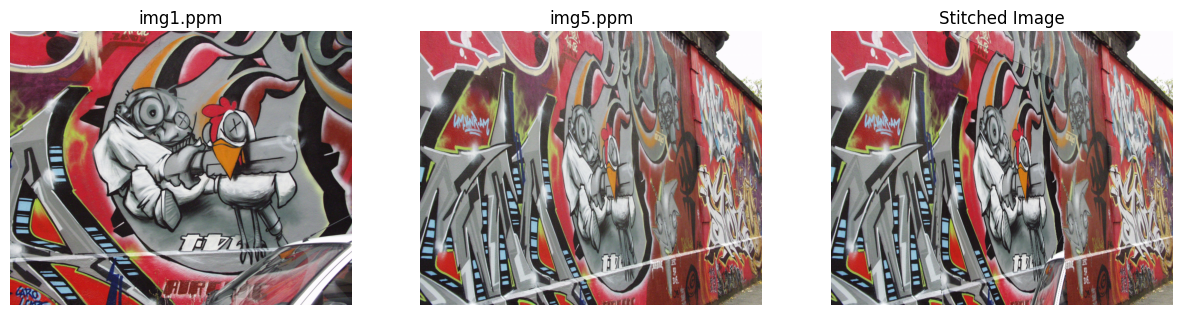

In [21]:
# Apply the homography to warp the first image to the perspective of the fifth image
img_p = cv2.warpPerspective(images[0], H1_H5, (images[4].shape[1], images[4].shape[0]))

ret, threshold = cv2.threshold(img_p, 10, 1, cv2.THRESH_BINARY_INV)

img2_thresholded = np.multiply(threshold, images[4])

img_blended = cv2.addWeighted(img2_thresholded, 1, img_p, 1, 0)

fig, ax = plt.subplots(1, 3, figsize=(15, 12))

# Display the figures
ax[0].imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
ax[0].set_title("img1.ppm")
ax[0].axis("off") 

ax[1].imshow(cv2.cvtColor(images[4], cv2.COLOR_BGR2RGB))
ax[1].set_title("img5.ppm")
ax[1].axis("off")  

ax[2].imshow(cv2.cvtColor(img_blended, cv2.COLOR_BGR2RGB))
ax[2].set_title("Stitched Image")
ax[2].axis("off")  

plt.show()
